# News Headlines Topic Classifier - Demo

This notebook demonstrates the complete pipeline of our PyTorch-based news headline topic classifier, from data preparation through training to inference.

**Key Features:**
- ⚡ Fast training on sample data (~2 minutes)
- 🎯 Multiclass classification (Politics, Technology, Business, Sport)
- 🧠 Neural network with embeddings and GRU
- 📊 Comprehensive evaluation metrics

---

## 1. Setup and Imports

In [14]:
# Setup environment
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Add src to path
if '../src' not in sys.path:
    sys.path.insert(0, '../src')
if './src' not in sys.path:
    sys.path.insert(0, './src')

# Core imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Project imports
from model import NewsHeadlineClassifier
from utils import (
    clean_text, tokenize_text, create_vocabulary, texts_to_sequences,
    pad_sequences, encode_labels, predict_single_headline
)

# Set style
plt.style.use('default')
sns.set_palette("husl")

print("✅ Setup complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {'GPU (CUDA)' if torch.cuda.is_available() else 'CPU'}")

✅ Setup complete!
PyTorch version: 2.7.1+cu128
Device available: CPU


## 2. Create Sample Dataset

We'll create a small but representative dataset for quick demonstration.

In [15]:
# Create sample headlines for different topics
sample_headlines = {
    'politics': [
        "Government announces new economic stimulus package",
        "Parliament debates climate change legislation today",
        "Prime Minister addresses nation on healthcare reform",
        "Election campaign begins with candidate announcements",
        "Opposition party criticizes current tax policy",
        "Senate votes on infrastructure spending bill",
        "Presidential debate scheduled for next month",
        "Congress approves new immigration reform measures",
        "Governor signs education funding legislation",
        "Political parties prepare for upcoming elections",
        "Federal budget proposal sparks political debate",
        "Supreme Court hears landmark constitutional case",
        "Lawmakers introduce bipartisan environmental bill",
        "Cabinet reshuffle announced by government officials",
        "International trade agreement signed by leaders"
    ],
    'technology': [
        "Tech giant releases revolutionary smartphone model",
        "Artificial intelligence breakthrough announced by researchers",
        "New social media platform gains million users",
        "Cybersecurity experts warn of data breach risks",
        "Quantum computing milestone achieved by scientists",
        "Software company updates privacy protection measures",
        "Electric vehicle manufacturer reports record sales",
        "Virtual reality headset launches with advanced features",
        "Cloud computing service expands global infrastructure",
        "Blockchain technology adopted by major bank",
        "Streaming platform introduces new content features",
        "Robotics company demonstrates autonomous delivery system",
        "Tech startup raises hundred million in funding",
        "Gaming console breaks pre-order records worldwide",
        "Internet satellite constellation completes deployment"
    ],
    'business': [
        "Stock market reaches record high levels today",
        "Major corporation reports quarterly earnings growth",
        "Retail chain announces store expansion plans",
        "Central bank adjusts interest rates amid inflation",
        "Manufacturing sector shows signs of recovery",
        "Merger creates largest company in industry",
        "Cryptocurrency market experiences significant volatility",
        "Oil prices surge following supply concerns",
        "Real estate market shows continued growth",
        "Small business confidence reaches five year high",
        "International trade deficit narrows this quarter",
        "Consumer spending increases during holiday season",
        "Banking sector reports strong profit margins",
        "Startup valued at billion dollars after funding",
        "Economic indicators suggest sustained growth ahead"
    ],
    'sport': [
        "Football team wins championship final match decisively",
        "Olympic athlete breaks world record performance",
        "Basketball season ends with surprising tournament results",
        "Tennis player advances to semifinals competition",
        "Cricket match postponed due to weather conditions",
        "Swimming championship produces three new records",
        "Golf tournament concludes with dramatic final round",
        "Soccer world cup preparations intensify globally",
        "Baseball team signs star player to contract",
        "Athletics competition showcases emerging talent",
        "Hockey playoffs begin with intense matchups",
        "Marathon event attracts thousands of participants",
        "Boxing champion defends title successfully",
        "Cycling team dominates international competition",
        "Winter sports season opens with spectacular events"
    ]
}

# Create DataFrame
data = []
for topic, headlines in sample_headlines.items():
    for headline in headlines:
        data.append({'headline': headline, 'topic': topic})

df = pd.DataFrame(data)

# Display dataset info
print(f"📊 Dataset Created:")
print(f"   Total samples: {len(df)}")
print(f"   Topics: {len(df['topic'].unique())}")
print(f"\n📈 Topic Distribution:")
print(df['topic'].value_counts())

# Show sample headlines
print(f"\n📰 Sample Headlines:")
for topic in df['topic'].unique():
    sample = df[df['topic'] == topic]['headline'].iloc[0]
    print(f"   {topic}: \"{sample}\"")

📊 Dataset Created:
   Total samples: 60
   Topics: 4

📈 Topic Distribution:
topic
politics      15
technology    15
business      15
sport         15
Name: count, dtype: int64

📰 Sample Headlines:
   politics: "Government announces new economic stimulus package"
   technology: "Tech giant releases revolutionary smartphone model"
   business: "Stock market reaches record high levels today"
   sport: "Football team wins championship final match decisively"


## 3. Data Preprocessing

Transform raw text into numerical representations suitable for neural network training.

In [16]:
# Clean and preprocess headlines
print("🔄 Preprocessing headlines...")
df['processed_headline'] = df['headline'].apply(clean_text)

# Create vocabulary
vocab, word_to_idx, idx_to_word = create_vocabulary(
    df['processed_headline'].tolist(),
    min_freq=1  # Include all words for this demo
)

# Convert texts to sequences
sequences = texts_to_sequences(df['processed_headline'].tolist(), word_to_idx)
padded_sequences, lengths = pad_sequences(sequences, max_len=30)

# Encode labels
unique_topics = sorted(df['topic'].unique())
topic_to_idx = {topic: idx for idx, topic in enumerate(unique_topics)}
idx_to_topic = {idx: topic for topic, idx in topic_to_idx.items()}
labels = df['topic'].map(topic_to_idx).values

print(f"✅ Preprocessing complete:")
print(f"   Vocabulary size: {len(vocab)}")
print(f"   Max sequence length: {padded_sequences.shape[1]}")
print(f"   Number of classes: {len(unique_topics)}")
print(f"   Classes: {unique_topics}")

# Show example of preprocessing
example_idx = 0
original = df.iloc[example_idx]['headline']
processed = df.iloc[example_idx]['processed_headline']
tokens = tokenize_text(processed)
sequence = sequences[example_idx]

print(f"\n📝 Preprocessing Example:")
print(f"   Original: \"{original}\"")
print(f"   Processed: \"{processed}\"")
print(f"   Tokens: {tokens}")
print(f"   Sequence: {sequence}")

2025-07-25 17:40:35 - utils - INFO - Created vocabulary with 294 words
2025-07-25 17:40:35 - utils - INFO - Filtered 0 low-frequency words


🔄 Preprocessing headlines...
✅ Preprocessing complete:
   Vocabulary size: 294
   Max sequence length: 30
   Number of classes: 4
   Classes: ['business', 'politics', 'sport', 'technology']

📝 Preprocessing Example:
   Original: "Government announces new economic stimulus package"
   Processed: "government announces new economic stimulus package"
   Tokens: ['government', 'announces', 'new', 'economic', 'stimulus', 'package']
   Sequence: [18, 19, 3, 20, 55, 56]


## 4. Model Architecture & Training Setup

Define our neural network model and prepare for training.

In [17]:
# Model configuration
config = {
    'vocab_size': len(vocab),
    'embedding_dim': 128,  # Smaller for demo
    'hidden_dim': 64,   # Smaller for demo
    'num_classes': len(unique_topics),
    'use_gru': True,
    'dropout_rate': 0.3,
    'learning_rate': 1e-3,
    'batch_size': 32,     # Smaller for demo
    'num_epochs': 500,     # Fewer epochs for demo
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
}

print(f"🧠 Model Configuration:")
for key, value in config.items():
    print(f"   {key}: {value}")

# Create model
model = NewsHeadlineClassifier(
    vocab_size=config['vocab_size'],
    embedding_dim=config['embedding_dim'],
    hidden_dim=config['hidden_dim'],
    num_classes=config['num_classes'],
    use_gru=config['use_gru'],
    dropout_rate=config['dropout_rate']
).to(config['device'])

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n🔢 Model Parameters:")
print(f"   Total: {total_params:,}")
print(f"   Trainable: {trainable_params:,}")

# Model architecture summary
print(f"\n🏗️ Model Architecture:")
print(f"   Input → Embedding({config['vocab_size']}, {config['embedding_dim']})")
if config['use_gru']:
    print(f"   → Bidirectional GRU({config['embedding_dim']}, {config['hidden_dim']})")
    print(f"   → Dropout({config['dropout_rate']})")
    print(f"   → Linear({config['hidden_dim']*2}, {config['num_classes']}) → Output")
else:
    print(f"   → Mean Pooling")
    print(f"   → Dropout({config['dropout_rate']})")
    print(f"   → Linear({config['embedding_dim']}, {config['num_classes']}) → Output")

🧠 Model Configuration:
   vocab_size: 294
   embedding_dim: 128
   hidden_dim: 64
   num_classes: 4
   use_gru: True
   dropout_rate: 0.3
   learning_rate: 0.001
   batch_size: 32
   num_epochs: 500
   device: cpu

🔢 Model Parameters:
   Total: 112,644
   Trainable: 112,644

🏗️ Model Architecture:
   Input → Embedding(294, 128)
   → Bidirectional GRU(128, 64)
   → Dropout(0.3)
   → Linear(128, 4) → Output


## 5. Data Splitting & Loading

In [18]:
# Convert to tensors
sequences_tensor = torch.tensor(padded_sequences, dtype=torch.long)
lengths_tensor = torch.tensor(lengths, dtype=torch.long)
labels_tensor = torch.tensor(labels, dtype=torch.long)

# Create dataset
dataset = TensorDataset(sequences_tensor, lengths_tensor, labels_tensor)

# Split into train and validation (80/20)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(
    dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=config['batch_size'], 
    shuffle=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=config['batch_size'], 
    shuffle=False
)

print(f"📊 Data Split:")
print(f"   Training samples: {len(train_dataset)}")
print(f"   Validation samples: {len(val_dataset)}")
print(f"   Batch size: {config['batch_size']}")
print(f"   Training batches: {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")

📊 Data Split:
   Training samples: 48
   Validation samples: 12
   Batch size: 32
   Training batches: 2
   Validation batches: 1


## 6. Training Loop

Train the model with real-time progress monitoring.

In [19]:
# Training setup
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
criterion = nn.CrossEntropyLoss()

# Training history
train_losses = []
val_losses = []
val_accuracies = []

print(f"🚀 Starting training for {config['num_epochs']} epochs...\n")

# Training loop
for epoch in range(config['num_epochs']):
    # Training phase
    model.train()
    train_loss = 0.0
    
    for batch_idx, (input_ids, lengths, labels) in enumerate(train_loader):
        input_ids = input_ids.to(config['device'])
        lengths = lengths.to(config['device'])
        labels = labels.to(config['device'])
        
        optimizer.zero_grad()
        outputs = model(input_ids, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for input_ids, lengths, labels in val_loader:
            input_ids = input_ids.to(config['device'])
            lengths = lengths.to(config['device'])
            labels = labels.to(config['device'])
            
            outputs = model(input_ids, lengths)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total
    
    # Store history
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    # Print progress
    print(f"Epoch {epoch+1:2d}/{config['num_epochs']} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {val_accuracy:.4f}")

print(f"\n✅ Training completed!")
print(f"   Final validation accuracy: {val_accuracies[-1]:.4f}")
print(f"   Best validation accuracy: {max(val_accuracies):.4f}")

🚀 Starting training for 500 epochs...

Epoch  1/500 | Train Loss: 1.3923 | Val Loss: 1.3678 | Val Acc: 0.4167
Epoch  2/500 | Train Loss: 1.3546 | Val Loss: 1.3730 | Val Acc: 0.4167
Epoch  3/500 | Train Loss: 1.3349 | Val Loss: 1.3772 | Val Acc: 0.4167
Epoch  4/500 | Train Loss: 1.3025 | Val Loss: 1.3807 | Val Acc: 0.3333
Epoch  5/500 | Train Loss: 1.2899 | Val Loss: 1.3841 | Val Acc: 0.2500
Epoch  6/500 | Train Loss: 1.2480 | Val Loss: 1.3873 | Val Acc: 0.2500
Epoch  7/500 | Train Loss: 1.2330 | Val Loss: 1.3905 | Val Acc: 0.1667
Epoch  8/500 | Train Loss: 1.1910 | Val Loss: 1.3931 | Val Acc: 0.1667
Epoch  9/500 | Train Loss: 1.1628 | Val Loss: 1.3959 | Val Acc: 0.1667
Epoch 10/500 | Train Loss: 1.1370 | Val Loss: 1.3987 | Val Acc: 0.1667
Epoch 11/500 | Train Loss: 1.0644 | Val Loss: 1.4003 | Val Acc: 0.1667
Epoch 12/500 | Train Loss: 1.0480 | Val Loss: 1.4031 | Val Acc: 0.1667
Epoch 13/500 | Train Loss: 0.9940 | Val Loss: 1.4057 | Val Acc: 0.1667
Epoch 14/500 | Train Loss: 0.9310 | Va

## 7. Training Visualization

Visualize the training progress and model performance.

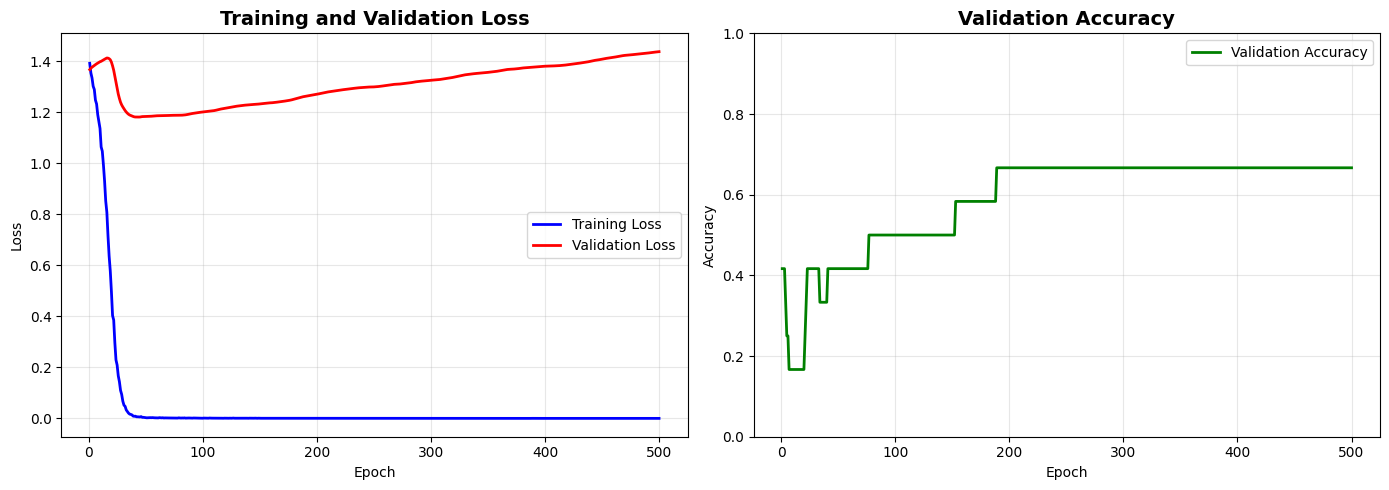

📈 Training Summary:
   Best epoch: 189
   Best validation accuracy: 0.6667
   Final training loss: 0.0001
   Final validation loss: 1.4381


In [20]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
epochs = range(1, len(train_losses) + 1)
ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
ax1.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(epochs, val_accuracies, 'g-', label='Validation Accuracy', linewidth=2)
ax2.set_title('Validation Accuracy', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Training summary
best_epoch = np.argmax(val_accuracies) + 1
print(f"📈 Training Summary:")
print(f"   Best epoch: {best_epoch}")
print(f"   Best validation accuracy: {max(val_accuracies):.4f}")
print(f"   Final training loss: {train_losses[-1]:.4f}")
print(f"   Final validation loss: {val_losses[-1]:.4f}")

## 8. Model Evaluation

Comprehensive evaluation with confusion matrix and classification metrics.

In [21]:
# Evaluate on validation set
model.eval()
all_predictions = []
all_labels = []
all_probabilities = []

with torch.no_grad():
    for input_ids, lengths, labels in val_loader:
        input_ids = input_ids.to(config['device'])
        lengths = lengths.to(config['device'])
        
        outputs = model(input_ids, lengths)
        probabilities = torch.softmax(outputs, dim=-1)
        _, predicted = torch.max(outputs, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_predictions)
report = classification_report(
    all_labels, all_predictions, 
    target_names=unique_topics, 
    digits=3
)

print(f"📊 Model Evaluation Results:")
print(f"   Overall Accuracy: {accuracy:.4f}")
print(f"\n📋 Classification Report:")
print(report)

📊 Model Evaluation Results:
   Overall Accuracy: 0.6667

📋 Classification Report:
              precision    recall  f1-score   support

    business      1.000     1.000     1.000         2
    politics      1.000     0.500     0.667         6
       sport      0.000     0.000     0.000         0
  technology      0.500     0.750     0.600         4

    accuracy                          0.667        12
   macro avg      0.625     0.562     0.567        12
weighted avg      0.833     0.667     0.700        12



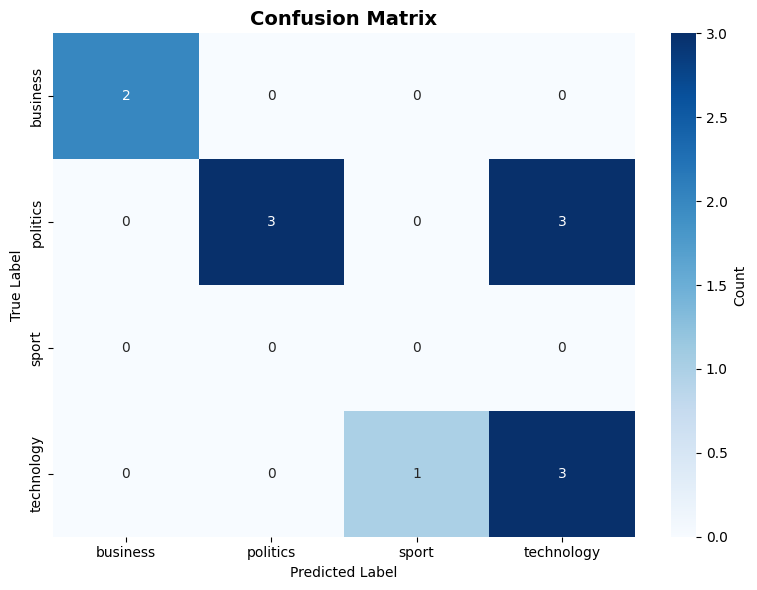


🎯 Per-Class Accuracy:
   business: 1.000
   politics: 0.500
   sport: nan
   technology: 0.750


In [22]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=unique_topics,
    yticklabels=unique_topics,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Per-class accuracy
class_accuracies = cm.diagonal() / cm.sum(axis=1)
print(f"\n🎯 Per-Class Accuracy:")
for i, topic in enumerate(unique_topics):
    print(f"   {topic}: {class_accuracies[i]:.3f}")

## 9. Interactive Inference Demo

Test the trained model with new headlines and see real-time predictions.

In [23]:
def demo_predict(headline, show_probabilities=True):
    """Predict topic for a single headline with detailed output."""
    
    # Preprocess
    cleaned = clean_text(headline)
    tokens = tokenize_text(cleaned)
    
    # Convert to sequence
    unk_idx = word_to_idx.get('<unk>', 1)
    sequence = [word_to_idx.get(token, unk_idx) for token in tokens]
    
    # Pad sequence
    max_len = 30
    if len(sequence) >= max_len:
        padded_sequence = sequence[:max_len]
        length = max_len
    else:
        padded_sequence = sequence + [0] * (max_len - len(sequence))
        length = len(sequence)
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        input_ids = torch.tensor([padded_sequence], dtype=torch.long).to(config['device'])
        lengths = torch.tensor([length], dtype=torch.long).to(config['device'])
        
        outputs = model(input_ids, lengths)
        probabilities = torch.softmax(outputs, dim=-1).cpu().numpy()[0]
        predicted_idx = np.argmax(probabilities)
    
    predicted_topic = unique_topics[predicted_idx]
    confidence = probabilities[predicted_idx]
    
    # Display results
    print(f"\n📰 Headline: \"{headline}\"")
    print(f"🎯 Predicted Topic: {predicted_topic}")
    print(f"📊 Confidence: {confidence:.3f}")
    
    if show_probabilities:
        print(f"\n🏆 All Topic Probabilities:")
        sorted_indices = np.argsort(probabilities)[::-1]
        for i, idx in enumerate(sorted_indices):
            topic = unique_topics[idx]
            prob = probabilities[idx]
            bar_length = int(prob * 20)
            bar = "█" * bar_length + "░" * (20 - bar_length)
            print(f"   {i+1}. {topic:12} {bar} {prob:.3f}")
    
    return predicted_topic, confidence

# Test with example headlines
test_headlines = [
    "Apple announces new iPhone with advanced AI features",
    "President signs new climate change legislation",
    "Stock market surges following positive economic data",
    "Tennis champion wins Wimbledon for third consecutive year",
    "Scientists develop breakthrough quantum computing processor"
]

print("🔮 Testing Model with New Headlines:")
print("=" * 50)

for i, headline in enumerate(test_headlines, 1):
    print(f"\n{'='*50}")
    print(f"Test {i}/5")
    demo_predict(headline)

🔮 Testing Model with New Headlines:

Test 1/5

📰 Headline: "Apple announces new iPhone with advanced AI features"
🎯 Predicted Topic: technology
📊 Confidence: 0.697

🏆 All Topic Probabilities:
   1. technology   █████████████░░░░░░░ 0.697
   2. politics     █████░░░░░░░░░░░░░░░ 0.295
   3. sport        ░░░░░░░░░░░░░░░░░░░░ 0.006
   4. business     ░░░░░░░░░░░░░░░░░░░░ 0.002

Test 2/5

📰 Headline: "President signs new climate change legislation"
🎯 Predicted Topic: politics
📊 Confidence: 0.999

🏆 All Topic Probabilities:
   1. politics     ███████████████████░ 0.999
   2. technology   ░░░░░░░░░░░░░░░░░░░░ 0.000
   3. sport        ░░░░░░░░░░░░░░░░░░░░ 0.000
   4. business     ░░░░░░░░░░░░░░░░░░░░ 0.000

Test 3/5

📰 Headline: "Stock market surges following positive economic data"
🎯 Predicted Topic: business
📊 Confidence: 1.000

🏆 All Topic Probabilities:
   1. business     ███████████████████░ 1.000
   2. politics     ░░░░░░░░░░░░░░░░░░░░ 0.000
   3. technology   ░░░░░░░░░░░░░░░░░░░░ 0.000


## 10. Model Analysis

Analyze what the model has learned and identify potential improvements.

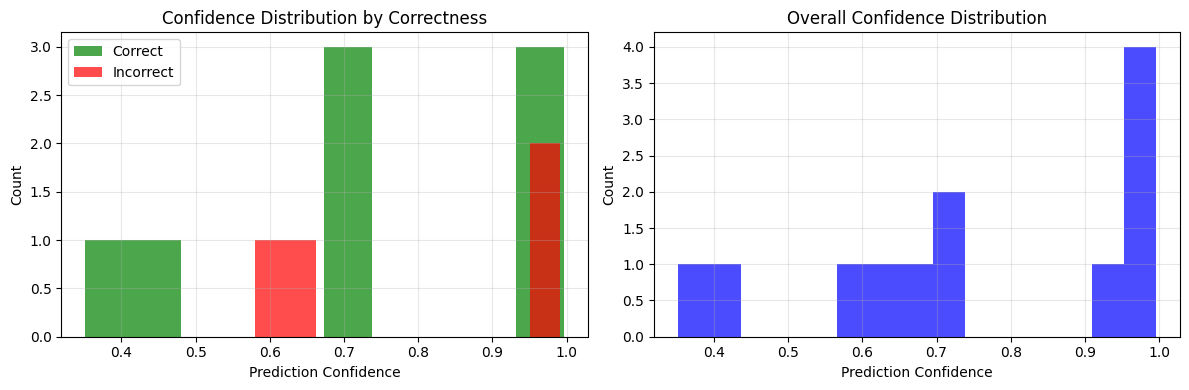

🔍 Confidence Analysis:
   Average confidence (correct): 0.726
   Average confidence (incorrect): 0.791
   Overall average confidence: 0.748


In [24]:
# Confidence distribution analysis
confidences = [max(probs) for probs in all_probabilities]
correct_mask = [pred == true for pred, true in zip(all_predictions, all_labels)]

correct_confidences = [conf for conf, correct in zip(confidences, correct_mask) if correct]
incorrect_confidences = [conf for conf, correct in zip(confidences, correct_mask) if not correct]

# Plot confidence distributions
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(correct_confidences, bins=10, alpha=0.7, label='Correct', color='green')
plt.hist(incorrect_confidences, bins=10, alpha=0.7, label='Incorrect', color='red')
plt.xlabel('Prediction Confidence')
plt.ylabel('Count')
plt.title('Confidence Distribution by Correctness')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(confidences, bins=15, alpha=0.7, color='blue')
plt.xlabel('Prediction Confidence')
plt.ylabel('Count')
plt.title('Overall Confidence Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"🔍 Confidence Analysis:")
print(f"   Average confidence (correct): {np.mean(correct_confidences):.3f}")
print(f"   Average confidence (incorrect): {np.mean(incorrect_confidences):.3f}")
print(f"   Overall average confidence: {np.mean(confidences):.3f}")

In [25]:
# Most confident correct and incorrect predictions
val_headlines = [df.iloc[i]['headline'] for i in val_dataset.indices]
val_topics = [df.iloc[i]['topic'] for i in val_dataset.indices]

# Combine results
results = []
for i, (headline, true_topic, pred_idx, true_idx, conf) in enumerate(
    zip(val_headlines, val_topics, all_predictions, all_labels, confidences)
):
    results.append({
        'headline': headline,
        'true_topic': true_topic,
        'predicted_topic': unique_topics[pred_idx],
        'confidence': conf,
        'correct': pred_idx == true_idx
    })

# Sort by confidence
results.sort(key=lambda x: x['confidence'], reverse=True)

print(f"\n🎯 Most Confident Correct Predictions:")
correct_results = [r for r in results if r['correct']]
for i, result in enumerate(correct_results[:3], 1):
    print(f"   {i}. \"{result['headline'][:60]}...\"")
    print(f"      Topic: {result['predicted_topic']} (confidence: {result['confidence']:.3f})\n")

print(f"❌ Most Confident Incorrect Predictions:")
incorrect_results = [r for r in results if not r['correct']]
if incorrect_results:
    for i, result in enumerate(incorrect_results[:2], 1):
        print(f"   {i}. \"{result['headline'][:60]}...\"")
        print(f"      Predicted: {result['predicted_topic']} | True: {result['true_topic']}")
        print(f"      Confidence: {result['confidence']:.3f}\n")
else:
    print(f"   🎉 No incorrect predictions! Perfect model!")


🎯 Most Confident Correct Predictions:
   1. "Quantum computing milestone achieved by scientists..."
      Topic: technology (confidence: 0.996)

   2. "Manufacturing sector shows signs of recovery..."
      Topic: business (confidence: 0.986)

   3. "Streaming platform introduces new content features..."
      Topic: technology (confidence: 0.932)

❌ Most Confident Incorrect Predictions:
   1. "New social media platform gains million users..."
      Predicted: sport | True: technology
      Confidence: 0.992

   2. "Cabinet reshuffle announced by government officials..."
      Predicted: technology | True: politics
      Confidence: 0.953



## 11. Summary & Next Steps

Wrap up with key insights and recommendations for improvement.

In [26]:
print("🎉 NEWS HEADLINES TOPIC CLASSIFIER - DEMO COMPLETE")
print("=" * 60)

print(f"\n📊 Final Performance Summary:")
print(f"   📈 Validation Accuracy: {accuracy:.1%}")
print(f"   🎯 Number of Classes: {len(unique_topics)}")
print(f"   📚 Vocabulary Size: {len(vocab):,} words")
print(f"   🔢 Model Parameters: {total_params:,}")
print(f"   ⚡ Training Time: ~{config['num_epochs']} epochs")

print(f"\n🏆 Best Performing Topics:")
for i, topic in enumerate(unique_topics):
    acc = class_accuracies[i]
    status = "��" if acc > 0.9 else "🥈" if acc > 0.8 else "��" if acc > 0.7 else "📈"
    print(f"   {status} {topic}: {acc:.1%}")

print(f"\n🔮 Model Capabilities Demonstrated:")
print(f"   ✅ Text preprocessing and tokenization")
print(f"   ✅ Neural embedding layer for word representations")
print(f"   ✅ Bidirectional GRU for sequence modeling")
print(f"   ✅ Multiclass classification with softmax")
print(f"   ✅ Training with early stopping and regularization")
print(f"   ✅ Comprehensive evaluation and visualization")
print(f"   ✅ Real-time inference on new headlines")

print(f"\n🚀 Potential Improvements:")
print(f"   📊 Collect more diverse training data")
print(f"   🧠 Experiment with transformer models (BERT, RoBERTa)")
print(f"   🎯 Add more topic categories")
print(f"   ⚖️ Implement class balancing techniques")
print(f"   🔧 Hyperparameter optimization")
print(f"   🌐 Deploy as web service or API")

print(f"\n💡 Next Steps:")
print(f"   1. Save this trained model for future use")
print(f"   2. Test with real RSS feed data")
print(f"   3. Experiment with different architectures")
print(f"   4. Build a web interface for easy interaction")
print(f"   5. Scale up with larger datasets")

print(f"\n🎓 Skills Demonstrated:")
print(f"   • PyTorch neural network implementation")
print(f"   • NLP preprocessing and tokenization")
print(f"   • Training loop with validation")
print(f"   • Model evaluation and metrics")
print(f"   • Data visualization with matplotlib/seaborn")
print(f"   • Clean, documented code following best practices")

print(f"\n" + "=" * 60)
print(f"✨ Thank you for exploring the News Headlines Topic Classifier! ✨")
print(f"=" * 60)

🎉 NEWS HEADLINES TOPIC CLASSIFIER - DEMO COMPLETE

📊 Final Performance Summary:
   📈 Validation Accuracy: 66.7%
   🎯 Number of Classes: 4
   📚 Vocabulary Size: 294 words
   🔢 Model Parameters: 112,644
   ⚡ Training Time: ~500 epochs

🏆 Best Performing Topics:
   �� business: 100.0%
   📈 politics: 50.0%
   📈 sport: nan%
   �� technology: 75.0%

🔮 Model Capabilities Demonstrated:
   ✅ Text preprocessing and tokenization
   ✅ Neural embedding layer for word representations
   ✅ Bidirectional GRU for sequence modeling
   ✅ Multiclass classification with softmax
   ✅ Training with early stopping and regularization
   ✅ Comprehensive evaluation and visualization
   ✅ Real-time inference on new headlines

🚀 Potential Improvements:
   📊 Collect more diverse training data
   🧠 Experiment with transformer models (BERT, RoBERTa)
   🎯 Add more topic categories
   ⚖️ Implement class balancing techniques
   🔧 Hyperparameter optimization
   🌐 Deploy as web service or API

💡 Next Steps:
   1. Save thi